In [98]:
import numpy        as np
import os
from os             import listdir
from datetime       import datetime
import matplotlib.pyplot as plt
import matplotlib        as mpl
from natsort import natsorted

In [11]:
class ChemTorchMod():
    '''
    Object representing 1 ChemTorch model.
    Contains:
        - n     [2d np.array]: Abundances at different timesteps
        - tstep [1d np.array]: Timesteps that the classical ODE solver is evaluated
        - p     [1d np.array]: input of the model -> [rho, T, delta, Av]
    '''
    def __init__(self, dirname, dir=None):
        outpath = '/STER/silkem/ChemTorch/out/'
        
        self.n      = np.load(outpath+dirname+'/'+dir+'/abundances.npy')[:,1:] # type: ignore
        self.tstep  = np.load(outpath+dirname+'/'+dir+'/tstep.npy') # type: ignore
        input       = np.load(outpath+dirname+'/'+dir+'/input.npy') # type: ignore
        self.p      = input[0:-1]
        self.tictoc = np.load(outpath+dirname+'/'+dir+'/tictoc.npy') # type: ignore

    def __len__(self):
        return len(self.tstep)
    

class CSEmod():
    '''
    Class to initialise the dataset to train & test emulator

    Get data from textfiles (output CSE model)
    
    Preprocess:
        - set all abundances < cutoff to cutoff
        - take np.log10 of abudances

    '''
    def __init__(self, dir=None, file=None):
        data = []

        if dir != None:
            locs = os.listdir(dir) 

            for i in range(1,len(locs)+1):
                name = dir+'csfrac_smooth_'+str(i)+'.out'
                proper = read_data_1Dmodel(name)
                data.append(proper)
        
        if file != None:
            proper = read_data_1Dmodel(file)
            data.append(proper)

        df = np.concatenate(data)

        self.n = df

def read_data_1Dmodel(file_name):
    '''
    Read data text file of output abundances of 1D CSE models
    '''
    with open(file_name, 'r') as file:
        dirty = []
        proper = None
        for line in file:
            try:  
                if len(line) > 1: 
                    dirty.append([float(el) for el in line.split()])
            except:
                if len(dirty) != 0:
                    dirty = np.array(dirty)[:,1:]
                    if proper is None:
                        proper = dirty
                    else:
                        proper = np.concatenate((proper, dirty), axis = 1)
                dirty = []
    return proper


In [156]:
outpath = '/STER/silkem/ChemTorch/out/'
dirname = 'bm_1'
dirs = listdir(outpath+dirname+'/')
dirs.remove('meta.json')
dirs = natsorted(dirs)

In [157]:
abs = []
p = []
dt = []

for i in range(len(dirs)):
    chem = ChemTorchMod(dirname, dirs[i])
    abs.append(chem.n.T[-1])
    dt.append(chem.tstep[-1])
    p.append(chem.p)

abs = np.array(abs)

In [143]:
time = np.zeros(len(dt))

for i in range(1,len(dt)):
    time[i] = 1+dt[i-1]+dt[i]

time

array([0.000e+00, 1.072e+00, 1.148e+00, 1.158e+00, 1.170e+00, 1.183e+00,
       1.196e+00, 1.209e+00, 1.224e+00, 1.240e+00, 1.257e+00, 1.276e+00,
       1.296e+00, 1.317e+00, 1.339e+00, 1.363e+00, 1.390e+00, 1.418e+00,
       1.447e+00, 1.479e+00, 1.514e+00, 1.551e+00, 1.590e+00, 1.632e+00,
       1.677e+00, 1.725e+00, 1.778e+00, 1.834e+00, 1.892e+00, 1.956e+00,
       2.025e+00, 2.098e+00, 2.177e+00, 2.261e+00, 2.350e+00, 2.448e+00,
       2.550e+00, 2.660e+00, 2.780e+00, 2.910e+00, 3.050e+00, 3.190e+00,
       3.350e+00, 3.520e+00, 3.690e+00, 3.890e+00, 4.100e+00, 4.310e+00,
       4.550e+00, 4.810e+00, 5.080e+00, 5.370e+00, 5.690e+00, 6.020e+00,
       6.380e+00, 6.770e+00, 7.170e+00, 7.620e+00, 8.090e+00, 8.590e+00,
       9.150e+00, 9.730e+00, 1.034e+01, 1.101e+01, 1.174e+01, 1.251e+01,
       1.332e+01, 1.417e+01, 1.510e+01, 1.620e+01, 1.730e+01, 1.840e+01,
       1.960e+01, 2.100e+01, 2.250e+01, 2.390e+01, 2.550e+01, 2.740e+01,
       2.930e+01, 3.120e+01, 3.340e+01, 3.580e+01, 

In [ ]:
aim_t = [1.000e+00 1.072e+00 1.148e+00               1.230e+00 1.318e+00 1.413e+00 1.514e+00
 1.622e+00 1.738e+00 1.862e+00 1.995e+00 2.138e+00 2.291e+00 2.455e+00
 2.630e+00 2.818e+00 3.020e+00 3.236e+00 3.467e+00 3.715e+00 3.981e+00
 4.266e+00 4.571e+00 4.898e+00 5.248e+00 5.623e+00 6.026e+00 6.457e+00
 6.918e+00 7.413e+00 7.943e+00 8.511e+00 9.120e+00 9.772e+00 1.047e+01
 1.122e+01 1.202e+01 1.288e+01 1.380e+01 1.479e+01 1.585e+01 1.698e+01
 1.820e+01 1.950e+01 2.089e+01 2.239e+01 2.399e+01 2.570e+01 2.754e+01
 2.951e+01 3.162e+01 3.388e+01 3.631e+01 3.890e+01 4.169e+01 4.467e+01
 4.786e+01 5.129e+01 5.495e+01 5.888e+01 6.310e+01 6.761e+01 7.244e+01
 7.762e+01 8.318e+01 8.913e+01 9.550e+01 1.023e+02 1.096e+02 1.175e+02
 1.259e+02 1.349e+02 1.445e+02 1.549e+02 1.660e+02 1.778e+02 1.905e+02
 2.042e+02 2.188e+02 2.344e+02 2.512e+02 2.692e+02 2.884e+02 3.090e+02
 3.311e+02 3.548e+02 3.802e+02 4.074e+02 4.365e+02 4.677e+02 5.012e+02
 5.370e+02 5.754e+02 6.166e+02 6.607e+02 7.079e+02 7.586e+02 8.128e+02
 8.710e+02 9.333e+02 1.000e+03 1.072e+03 1.148e+03 1.230e+03 1.318e+03
 1.413e+03 1.514e+03 1.622e+03 1.738e+03 1.862e+03 1.995e+03 2.138e+03
 2.291e+03 2.455e+03 2.630e+03 2.818e+03 3.020e+03 3.236e+03 3.467e+03
 3.715e+03 3.981e+03 4.266e+03 4.571e+03 4.898e+03 5.248e+03 5.623e+03
 6.026e+03 6.457e+03 6.918e+03 7.413e+03 7.943e+03 8.511e+03 9.120e+03
 9.772e+03 1.047e+04]

In [135]:
np.array(dt)

array([0.00e+00, 7.20e-02, 7.60e-02, 8.20e-02, 8.80e-02, 9.50e-02,
       1.01e-01, 1.08e-01, 1.16e-01, 1.24e-01, 1.33e-01, 1.43e-01,
       1.53e-01, 1.64e-01, 1.75e-01, 1.88e-01, 2.02e-01, 2.16e-01,
       2.31e-01, 2.48e-01, 2.66e-01, 2.85e-01, 3.05e-01, 3.27e-01,
       3.50e-01, 3.75e-01, 4.03e-01, 4.31e-01, 4.61e-01, 4.95e-01,
       5.30e-01, 5.68e-01, 6.09e-01, 6.52e-01, 6.98e-01, 7.50e-01,
       8.00e-01, 8.60e-01, 9.20e-01, 9.90e-01, 1.06e+00, 1.13e+00,
       1.22e+00, 1.30e+00, 1.39e+00, 1.50e+00, 1.60e+00, 1.71e+00,
       1.84e+00, 1.97e+00, 2.11e+00, 2.26e+00, 2.43e+00, 2.59e+00,
       2.79e+00, 2.98e+00, 3.19e+00, 3.43e+00, 3.66e+00, 3.93e+00,
       4.22e+00, 4.51e+00, 4.83e+00, 5.18e+00, 5.56e+00, 5.95e+00,
       6.37e+00, 6.80e+00, 7.30e+00, 7.90e+00, 8.40e+00, 9.00e+00,
       9.60e+00, 1.04e+01, 1.11e+01, 1.18e+01, 1.27e+01, 1.37e+01,
       1.46e+01, 1.56e+01, 1.68e+01, 1.80e+01, 1.92e+01, 2.06e+01,
       2.21e+01, 2.37e+01, 2.54e+01, 2.72e+01, 2.91e+01, 3.12e

In [ ]:
[0.00e+00 7.20e-02 7.60e-02 8.20e-02 8.80e-02 9.50e-02 1.01e-01 1.08e-01
 1.16e-01 1.24e-01 1.33e-01 1.43e-01 1.53e-01 1.64e-01 1.75e-01 1.88e-01
 2.02e-01 2.16e-01 2.31e-01 2.48e-01 2.66e-01 2.85e-01 3.05e-01 3.27e-01
 3.50e-01 3.75e-01 4.03e-01 4.31e-01 4.61e-01 4.95e-01 5.30e-01 5.68e-01
 6.09e-01 6.52e-01 6.98e-01 7.50e-01 8.00e-01 8.60e-01 9.20e-01 9.90e-01
 1.06e+00 1.13e+00 1.22e+00 1.30e+00 1.39e+00 1.50e+00 1.60e+00 1.71e+00
 1.84e+00 1.97e+00 2.11e+00 2.26e+00 2.43e+00 2.59e+00 2.79e+00 2.98e+00
 3.19e+00 3.43e+00 3.66e+00 3.93e+00 4.22e+00 4.51e+00 4.83e+00 5.18e+00
 5.56e+00 5.95e+00 6.37e+00 6.80e+00 7.30e+00 7.90e+00 8.40e+00 9.00e+00
 9.60e+00 1.04e+01 1.11e+01 1.18e+01 1.27e+01 1.37e+01 1.46e+01 1.56e+01
 1.68e+01 1.80e+01 1.92e+01 2.06e+01 2.21e+01 2.37e+01 2.54e+01 2.72e+01
 2.91e+01 3.12e+01 3.35e+01 3.58e+01 3.84e+01 4.12e+01 4.41e+01 4.72e+01
 5.07e+01 5.42e+01 5.82e+01 6.23e+01 6.67e+01 7.20e+01 7.60e+01 8.20e+01
 8.80e+01 9.50e+01 1.01e+02 1.08e+02 1.16e+02 1.24e+02 1.33e+02 1.43e+02
 1.53e+02 1.64e+02 1.75e+02 1.88e+02 2.02e+02 2.16e+02 2.31e+02 2.48e+02
 2.66e+02 2.85e+02 3.05e+02 3.27e+02 3.50e+02 3.75e+02 4.03e+02 4.31e+02
 4.61e+02 4.95e+02 5.30e+02 5.68e+02 6.09e+02 6.52e+02 6.98e+02]





<function matplotlib.pyplot.show(close=None, block=None)>

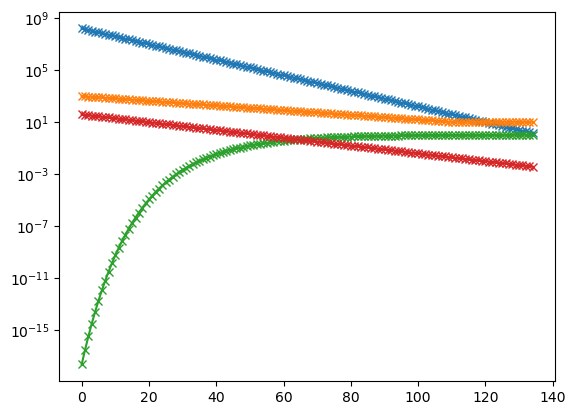

In [146]:
p = np.array(p)

plt.plot(p, '-x')

plt.yscale('log')

plt.show

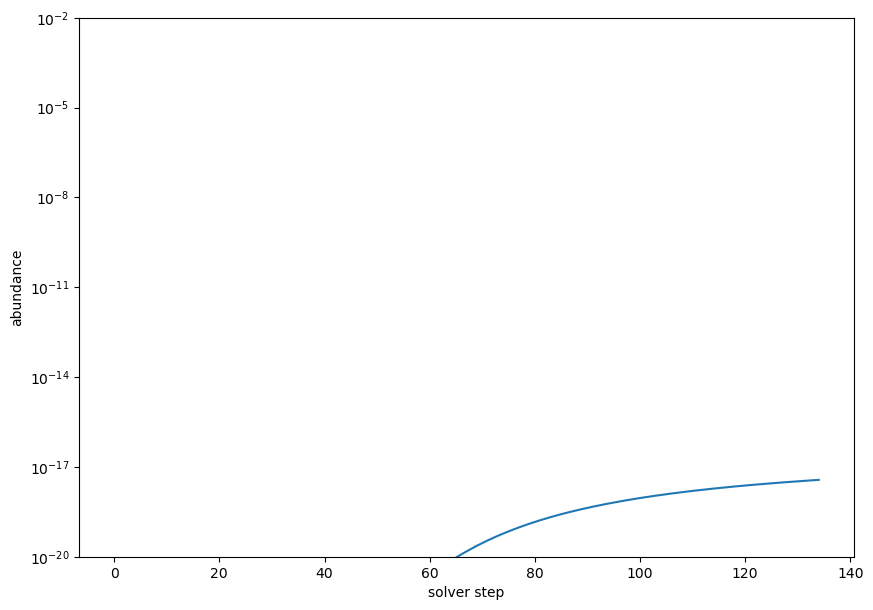

In [162]:
fig, ax1 = plt.subplots(figsize = (10,7)) 

ax1.plot(abs.T[39], '-')


ax1.set_yscale('log')
ax1.set_ylim([1e-20,1e-2])

ax1.set_xlabel('solver step')
ax1.set_ylabel('abundance')

plt.show()

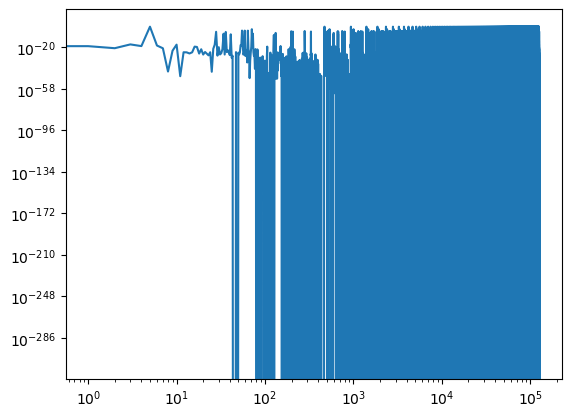

In [63]:
plt.loglog(abs.T)

[[ 3.38680775e-018  1.24936989e-019  1.68076946e-021 ...  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [ 3.45121172e-018  1.27291436e-019  1.71244372e-021 ...  8.49394041e-083
  -4.64931504e-122 -2.94389492e-104]
 [ 3.51567516e-018  1.29645883e-019  1.74411797e-021 ...  2.03464928e-082
  -8.84766011e-122 -4.33544404e-104]
 [ 3.91655595e-018  1.44213772e-019  1.94009907e-021 ...  2.08784623e-079
  -2.57690165e-117 -3.27171803e-100]]


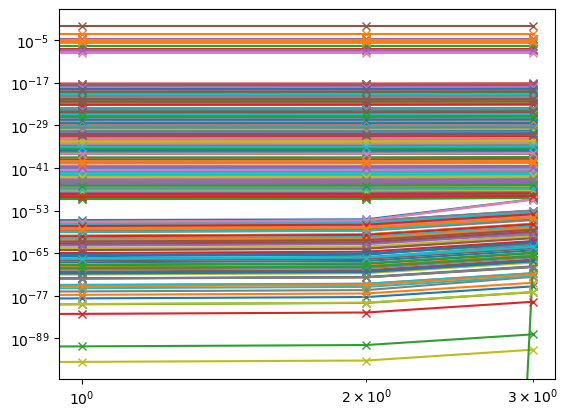

In [48]:
i = 0

print((abs[i]))
plt.loglog(abs[i], '-x')
plt.show()